In [1]:
# Part 1: Setup and Imports

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Union

# ML imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    GridSearchCV, StratifiedKFold
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    VotingClassifier
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    make_scorer,
    precision_recall_curve
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))



In [2]:
# Part 2: Data Loading and Preparation

print("Loading data and features...")
try:
    # Load processed data
    df = pd.read_pickle(PROJECT_ROOT / 'data/processed/processed_data.pkl')
    enhanced_features = pd.read_pickle(PROJECT_ROOT / 'data/processed/enhanced_features.pkl')
    X_combined = np.load(PROJECT_ROOT / 'data/processed/combined_features.npy')
    
    print(f"Data shape: {df.shape}")
    print(f"Enhanced features shape: {enhanced_features.shape}")
    print(f"Combined features shape: {X_combined.shape}")
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

Loading data and features...
Data shape: (1000, 22)
Enhanced features shape: (1000, 9)
Combined features shape: (1000, 404)


In [3]:
# Part 3: Feature Engineering

def prepare_features(combined_features: np.ndarray,
                     enhanced_features: pd.DataFrame) -> np.ndarray:
    """Combine all features for modeling"""
    print("\nPreparing feature matrix...")
    try:
        # Combine TF-IDF, Word2Vec, and enhanced features
        X = np.hstack([
            combined_features,
            enhanced_features.values
        ])
        print(f"Final feature matrix shape: {X.shape}")
        return X
    except Exception as e:
        print(f"Error preparing features: {str(e)}")
        raise

# Prepare features
X = prepare_features(X_combined, enhanced_features)
y = df['IsHatespeech'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



Preparing feature matrix...
Final feature matrix shape: (1000, 413)
Training set shape: (800, 413)
Test set shape: (200, 413)


In [10]:
# ## Part 4: Improved Model Implementation

# %%
# Additional necessary imports
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

class HateSpeechDetector:
    """
    Hate speech detection with focus on balanced performance and overfitting control
    """
    def __init__(self):
        # Random Forest with controlled complexity
        self.rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=3,           
            min_samples_leaf=10,    
            min_samples_split=15,
            max_features='sqrt',   
            class_weight={0: 1, 1: 3},  
            random_state=42
        )
        
        # Gradient Boosting with conservative settings
        self.gb = GradientBoostingClassifier(
            n_estimators=50,
            learning_rate=0.01,    
            max_depth=2,           
            subsample=0.6,         
            min_samples_leaf=6,
            min_samples_split=12,
            random_state=42
        )
        
        self.threshold = 0.35
    
    def fit(self, X_train, y_train):
        """Train models with validation"""
        try:
            # Split for threshold tuning
            X_train_main, X_val, y_train_main, y_val = train_test_split(
                X_train, y_train,
                test_size=0.15,
                stratify=y_train,
                random_state=42
            )
            
            # Train base models
            print("Training Random Forest...")
            self.rf.fit(X_train_main, y_train_main)
            
            print("Training Gradient Boosting...")
            self.gb.fit(X_train_main, y_train_main)
            
            # Tune threshold on validation set
            print("Tuning threshold...")
            y_prob_rf = self.rf.predict_proba(X_val)[:, 1]
            y_prob_gb = self.gb.predict_proba(X_val)[:, 1]
            
            # Weighted probabilities
            y_prob = 0.8 * y_prob_rf + 0.2 * y_prob_gb
            
            # Find best threshold
            best_f1 = 0
            best_threshold = 0.35
            
            for threshold in np.arange(0.25, 0.5, 0.02):
                y_pred = (y_prob > threshold).astype(int)
                # Focus on hate speech class
                f1 = f1_score(y_val, y_pred, pos_label=1)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            
            self.threshold = best_threshold
            return self
            
        except Exception as e:
            print(f"Error in model fitting: {str(e)}")
            raise
    
    def predict_proba(self, X):
        """Get weighted probability predictions"""
        try:
            rf_prob = self.rf.predict_proba(X)[:, 1]
            gb_prob = self.gb.predict_proba(X)[:, 1]
            return 0.7 * rf_prob + 0.3 * gb_prob
        except Exception as e:
            print(f"Error in probability prediction: {str(e)}")
            raise
    
    def predict(self, X):
        """Make predictions using tuned threshold"""
        try:
            probas = self.predict_proba(X)
            return (probas > self.threshold).astype(int)
        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            raise


Starting model training and evaluation...
Starting model evaluation...
Training detector...
Training Random Forest...
Training Gradient Boosting...
Tuning threshold...
Getting predictions...

Model Performance:
Train Score: 0.7927
Test Score: 0.7739
Overfitting: 2.36%
Optimal Threshold: 0.25

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.76      0.83       172
        True       0.30      0.64      0.41        28

    accuracy                           0.74       200
   macro avg       0.61      0.70      0.62       200
weighted avg       0.84      0.74      0.77       200



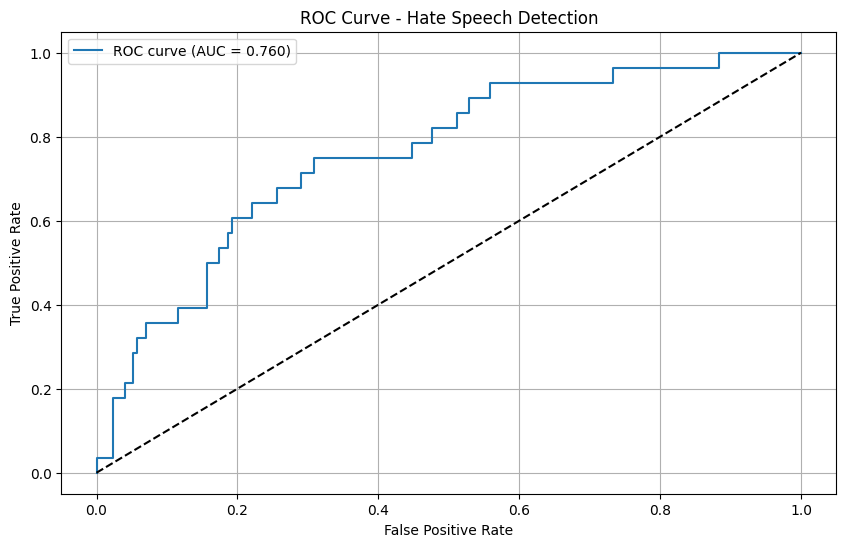

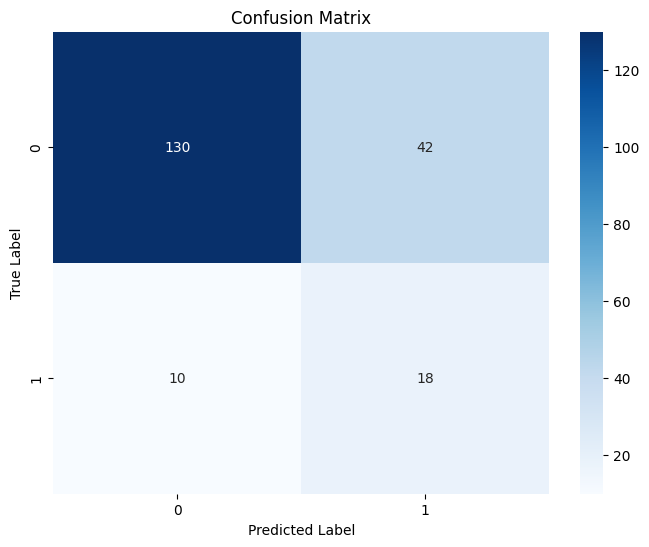


Saving model and results...
Model and results saved successfully!


In [11]:
# ## Part 5: Model Training and Evaluation

# %%
def evaluate_detector(X, y):
    """Evaluate detector with proper validation"""
    try:
        print("Starting model evaluation...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            stratify=y,
            random_state=42
        )
        
        print("Training detector...")
        detector = HateSpeechDetector()
        detector.fit(X_train, y_train)
        
        print("Getting predictions...")
        # Get predictions
        train_preds = detector.predict(X_train)
        test_preds = detector.predict(X_test)
        test_probs = detector.predict_proba(X_test)
        
        # Calculate metrics
        train_score = f1_score(y_train, train_preds, average='weighted')
        test_score = f1_score(y_test, test_preds, average='weighted')
        overfitting = ((train_score - test_score) / train_score) * 100
        
        # Print results
        print("\nModel Performance:")
        print(f"Train Score: {train_score:.4f}")
        print(f"Test Score: {test_score:.4f}")
        print(f"Overfitting: {overfitting:.2f}%")
        print(f"Optimal Threshold: {detector.threshold:.2f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, test_preds))
        
        # Visualizations
        plt.figure(figsize=(10, 6))
        fpr, tpr, _ = roc_curve(y_test, test_probs)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, test_probs):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Hate Speech Detection')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, test_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return detector, {
            'train_score': train_score,
            'test_score': test_score,
            'overfitting': overfitting,
            'threshold': detector.threshold,
            'roc_auc': roc_auc_score(y_test, test_probs),
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, test_preds, output_dict=True)
        }
        
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        raise

# %%
# Train and evaluate
print("Starting model training and evaluation...")
detector, results = evaluate_detector(X_combined, y)

# Save model and results
try:
    model_dir = PROJECT_ROOT / 'data' / 'models'
    model_dir.mkdir(parents=True, exist_ok=True)
    
    print("\nSaving model and results...")
    # Save model
    joblib.dump(detector, model_dir / 'hate_speech_detector.joblib')
    
    # Save results
    with open(model_dir / 'final_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    print("Model and results saved successfully!")
except Exception as e:
    print(f"Error saving results: {str(e)}")